# Application sur le Dow Jones Industrial Average

In [1]:
# Importations de bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg, optimize
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import covariance, cluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
import statsmodels.api as sm
from statsmodels import regression
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import timedelta


In [2]:
stocks = "Dow_Jones_Industrial_Average"
web = pd.read_html("https://en.wikipedia.org/wiki/{}".format(stocks))[1]

In [3]:
web.head()

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,1.54%
1,American Express,NYSE,AXP,Financial services,1982-08-30,NaN,3.64%
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,4.80%
3,Amazon,NASDAQ,AMZN,Retailing,2024-02-26,NaN,2.93%
4,Apple,NASDAQ,AAPL,Information technology,2015-03-19,NaN,3.04%


In [4]:
tickers = list(web.Symbol)

#Affichage des 5 premiers
tickers[:5]

['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL']

In [5]:
#Définition du début et fin de la collecte de données
start = '2015-01-01'
end = '2016-01-01'

#Collecte
data = yf.download(
    tickers,
    start,
    end
)
data.head()

[*********************100%%**********************]  30 of 30 completed

1 Failed download:
['DOW']: YFChartError("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1451624400")


Price       Adj Close                                                         \
Ticker           AAPL        AMGN     AMZN        AXP          BA        CAT   
Date                                                                           
2015-01-02  24.402168  122.031853  15.4260  80.772018  113.657211  70.907600   
2015-01-05  23.714724  120.581703  15.1095  78.635941  112.870056  67.164673   
2015-01-06  23.716951  116.696922  14.7645  76.960068  111.540634  66.732483   
2015-01-07  24.049519  120.772530  14.9210  78.640854  113.272377  67.766617   
2015-01-08  24.973555  120.337494  15.0230  79.755608  115.275284  68.461189   

Price                                                   ...   Volume  \
Ticker            CRM       CSCO        CVX        DIS  ...      MMM   
Date                                                    ...            
2015-01-02  59.162720  20.657431  75.044266  87.092422  ...  2531214   
2015-01-05  58.094112  20.245926  72.044624  85.819717  ...  4416708   
2015-01-06  57.125378  20.238445  72.011269  85.364487  ...  4224272   
2015-01-07  56.855732  20.425489  71.951286  86.237747  ...  3685235   
2015-01-08  58.513565  20.582609  73.597755  87.129562  ...  3758908   

Price                                                                         \
Ticker           MRK      MSFT      NKE       PG      TRV      UNH         V   
Date                                                                           
2015-01-02   7415962  27913900  4985800  7251400  1270800  3060900   8389600   
2015-01-05  16727338  39673900  6889200  8626100  1728700  4679000  12751200   
2015-01-06  25453510  36447900  7576000  7791200  2350900  3468300  11070000   
2015-01-07  19528956  29114100  7256000  5986600  1558200  3225800   9346800   
2015-01-08  20038808  29645200  5978200  6823300  1941200  5346100  10443200   

Price                           
Ticker            VZ       WMT  
Date                            
2015-01-02  11421200  13505400  
2015-01-05  18964500  20937000  
2015-01-06  22950100  24615300  
2015-01-07  20793600  25495200  
2015-01-08  17617500  38140800  

[5 rows x 180 columns]

In [6]:
failed_tickers = data.columns.get_level_values(1)[data.isnull().any() | (data == 0).any()].unique().tolist()
tickers = [ticker for ticker in tickers if ticker not in failed_tickers]

In [7]:
data.drop(columns=failed_tickers, level=1, inplace=True)
data.head()

Price       Adj Close                                                         \
Ticker           AAPL        AMGN     AMZN        AXP          BA        CAT   
Date                                                                           
2015-01-02  24.402168  122.031853  15.4260  80.772018  113.657211  70.907600   
2015-01-05  23.714724  120.581703  15.1095  78.635941  112.870056  67.164673   
2015-01-06  23.716951  116.696922  14.7645  76.960068  111.540634  66.732483   
2015-01-07  24.049519  120.772530  14.9210  78.640854  113.272377  67.766617   
2015-01-08  24.973555  120.337494  15.0230  79.755608  115.275284  68.461189   

Price                                                   ...   Volume  \
Ticker            CRM       CSCO        CVX        DIS  ...      MMM   
Date                                                    ...            
2015-01-02  59.162720  20.657431  75.044266  87.092422  ...  2531214   
2015-01-05  58.094112  20.245926  72.044624  85.819717  ...  4416708   
2015-01-06  57.125378  20.238445  72.011269  85.364487  ...  4224272   
2015-01-07  56.855732  20.425489  71.951286  86.237747  ...  3685235   
2015-01-08  58.513565  20.582609  73.597755  87.129562  ...  3758908   

Price                                                                         \
Ticker           MRK      MSFT      NKE       PG      TRV      UNH         V   
Date                                                                           
2015-01-02   7415962  27913900  4985800  7251400  1270800  3060900   8389600   
2015-01-05  16727338  39673900  6889200  8626100  1728700  4679000  12751200   
2015-01-06  25453510  36447900  7576000  7791200  2350900  3468300  11070000   
2015-01-07  19528956  29114100  7256000  5986600  1558200  3225800   9346800   
2015-01-08  20038808  29645200  5978200  6823300  1941200  5346100  10443200   

Price                           
Ticker            VZ       WMT  
Date                            
2015-01-02  11421200  13505400  
2015-01-05  18964500  20937000  
2015-01-06  22950100  24615300  
2015-01-07  20793600  25495200  
2015-01-08  17617500  38140800  

[5 rows x 174 columns]

In [8]:
data.columns

MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'AMGN'),
            ('Adj Close', 'AMZN'),
            ('Adj Close',  'AXP'),
            ('Adj Close',   'BA'),
            ('Adj Close',  'CAT'),
            ('Adj Close',  'CRM'),
            ('Adj Close', 'CSCO'),
            ('Adj Close',  'CVX'),
            ('Adj Close',  'DIS'),
            ...
            (   'Volume',  'MMM'),
            (   'Volume',  'MRK'),
            (   'Volume', 'MSFT'),
            (   'Volume',  'NKE'),
            (   'Volume',   'PG'),
            (   'Volume',  'TRV'),
            (   'Volume',  'UNH'),
            (   'Volume',    'V'),
            (   'Volume',   'VZ'),
            (   'Volume',  'WMT')],
           names=['Price', 'Ticker'], length=174)

In [9]:
s= set()
for column,_ in list(data.columns):
    s.add(column)
s

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

In [10]:
closing_prices = data["Close"]
opening_prices = data["Open"]

variation = closing_prices-opening_prices
variation.head()

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.514999,-0.270004,-0.203000,-0.150002,-1.120010,0.110001,-0.660000,-0.250000,0.950005,-1.160004,...,-0.543472,-0.028625,0.099998,-0.760002,-0.399994,-0.849998,-0.720001,0.409996,-0.040001,-0.123333
2015-01-05,-0.510000,0.560013,-0.241000,-1.900002,-0.610001,-3.320000,-0.430000,-0.260000,-2.879997,-0.900002,...,-2.207367,-0.162212,-0.039997,-0.505001,-0.220001,-0.940002,-1.180000,-1.079994,-0.510002,-0.023335
2015-01-06,-0.070000,-5.880005,-0.347501,-2.160004,-1.520004,-0.809998,-0.980000,-0.090000,0.159996,-0.680000,...,-1.814392,1.946564,-0.730000,-0.470001,-0.709999,-0.830002,-0.910004,-0.572502,0.250000,0.110001
2015-01-07,0.137501,4.150009,0.046000,-0.709999,0.769989,0.439995,-0.860001,0.160000,-1.309998,0.110001,...,-0.083603,1.116413,0.250000,0.630001,0.129997,0.620003,0.970001,0.627502,-0.730000,0.606667
2015-01-08,0.664999,-1.930008,0.007000,0.139999,1.199997,-0.470001,1.259998,-0.030001,1.220001,-0.080002,...,2.491638,0.811069,0.840000,0.699997,0.619995,1.330002,3.129997,0.312500,0.760002,0.420000


In [11]:
alphas = np.logspace(-1.5, 1, num=10)
model = covariance.GraphicalLassoCV(alphas=alphas)

X = variation.copy()
X /= X.std(axis=0)
model.fit(X)

c:\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.337e-04
  warnings.warn(


GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

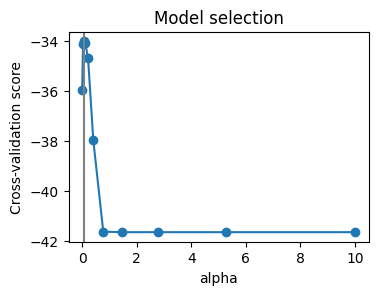

In [12]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

In [13]:
model.alpha_

0.05994842503189409

In [14]:
_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
n_labels

4

In [15]:
labels

array([2, 3, 1, 4, 2, 2, 0, 2, 4, 2, 4, 1, 2, 2, 2, 3, 4, 2, 3, 2, 3, 4,
       1, 3, 4, 3, 4, 2, 1], dtype=int64)

In [16]:
clusters = {}

for i in range(len(labels)):
    cluster = labels[i]+1
    if cluster not in clusters:
        clusters[cluster]=[]
    clusters[cluster].append(tickers[i])

for cluster in clusters:
    print("Cluster "+str(cluster)+" : "+",".join(clusters[cluster]))

Cluster 3 : MMM,AAPL,BA,CVX,KO,HD,HON,IBM,JPM,MRK,V
Cluster 4 : AXP,INTC,MCD,MSFT,CRM,UNH
Cluster 2 : AMGN,GS,PG,WMT
Cluster 5 : AMZN,CSCO,DIS,JNJ,NKE,TRV,VZ
Cluster 1 : CAT


In [17]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

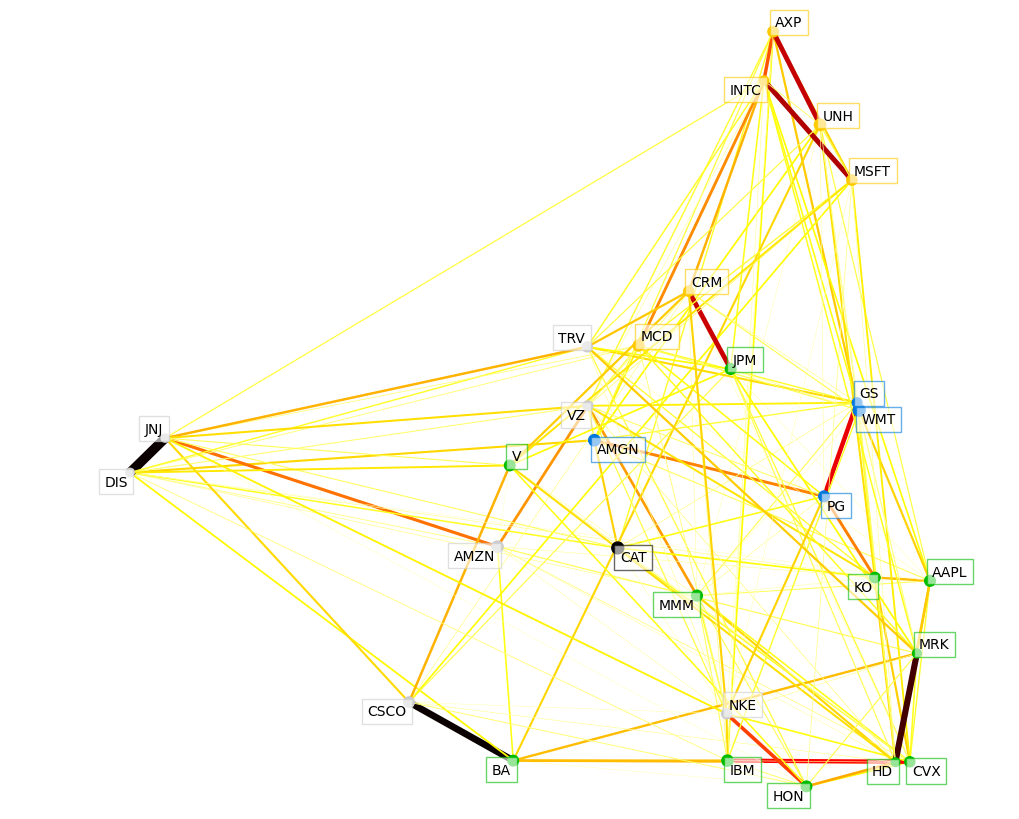

In [18]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")


partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

start_idx, end_idx = np.where(non_zero)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()